In [151]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Preprocessing

In [152]:
test_df = pd.read_csv("test_dataset_without_labels.csv", encoding='utf-16-le')
test_df

,vba_code
0,"Private Sub getCIA(C As String, I As String, A..."
1,Private Sub Workbook_Open()\n Application.C...
2,'APMP\n'KILL\nPrivate Sub Document_Open()\n ...
3,Private Sub Workbook_Activate()\n Call AddM...
4,Private Sub CheckBox1_Click()\n\nEnd Sub\n\nPr...
...,...
10625,Private Sub CommandButton1_Click()\nDim s As A...
10626,Sub AutoOpen()\n\nMyMacro\n\nEnd Sub\n\nSub Do...
10627,Private Sub CommandButton1_Click()\n With A...
10628,Private Const FOSMgcqLTaUItxmhNrJ As String = ...


In [153]:
test_df.isnull().sum()

vba_code    0
dtype: int64

In [154]:
validation_df = pd.read_csv("validation_dataset.csv", encoding='utf-16-le')
validation_df

,label,vba_code
0,mal,Function SleekM()\nOn Error Resume Next\n Se...
1,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...
2,white,"'Sub AutoExec() 'ð2¾(\n'ds = MsgBox(""#Wzh..."
3,white,Private Sub CommandButton1_Click()\nCall Clear...
4,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...
...,...,...
10624,mal,Sub Auto_Open()\nApplication.EnableCancelKey =...
10625,white,"Private Sub UserForm_Initialize()\nTXTpath = ""..."
10626,white,Private Sub SpinButton1_Change()\n\nEnd Sub\n\...
10627,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...


In [155]:
validation_df.isnull().sum()

label       0
vba_code    0
dtype: int64

In [156]:
train_df = pd.read_csv("train_dataset.csv", encoding='utf-16-le')
train_df

,label,vba_code
0,white,Private Sub Workbook_BeforeClose(Cancel As Boo...
1,white,Option Explicit\nOption Explicit\nOption Expli...
2,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...
3,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...
4,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...
...,...,...
31883,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...
31884,white,Option Explicit\n\nPrivate Sub Workbook_Open()...
31885,white,Option Explicit\n\nPrivate Sub CFixPicture_Act...
31886,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...


In [157]:
train_df.isnull().sum()

label       0
vba_code    0
dtype: int64

In [158]:
np.unique(train_df.label) 

array(['mal', 'white'], dtype=object)

In [159]:
train_df.vba_code

0        Private Sub Workbook_BeforeClose(Cancel As Boo...
1        Option Explicit\nOption Explicit\nOption Expli...
2        'Option Explicit\nPrivate Sub Workbook_BeforeC...
3        'Option Explicit\nPrivate Sub Workbook_BeforeC...
4        'Option Explicit\nPrivate Sub Workbook_BeforeC...
                               ...                        
31883    'Option Explicit\nPrivate Sub Workbook_BeforeC...
31884    Option Explicit\n\nPrivate Sub Workbook_Open()...
31885    Option Explicit\n\nPrivate Sub CFixPicture_Act...
31886    'Option Explicit\nPrivate Sub Workbook_BeforeC...
31887    'Option Explicit\nPrivate Sub Workbook_BeforeC...
Name: vba_code, Length: 31888, dtype: object

In [160]:
# train_df.vba_code[2]

In [161]:
# Remove comments
train_df['vba_code_without_comments'] = train_df['vba_code'].apply(lambda x: re.sub(r"'.*?$", "", x, flags=re.MULTILINE))
train_df

,label,vba_code,vba_code_without_comments
0,white,Private Sub Workbook_BeforeClose(Cancel As Boo...,Private Sub Workbook_BeforeClose(Cancel As Boo...
1,white,Option Explicit\nOption Explicit\nOption Expli...,Option Explicit\nOption Explicit\nOption Expli...
2,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,\nPrivate Sub Workbook_BeforeClose(Cancel As B...
3,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,\nPrivate Sub Workbook_BeforeClose(Cancel As B...
4,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,\nPrivate Sub Workbook_BeforeClose(Cancel As B...
...,...,...,...
31883,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,\nPrivate Sub Workbook_BeforeClose(Cancel As B...
31884,white,Option Explicit\n\nPrivate Sub Workbook_Open()...,Option Explicit\n\nPrivate Sub Workbook_Open()...
31885,white,Option Explicit\n\nPrivate Sub CFixPicture_Act...,Option Explicit\n\nPrivate Sub CFixPicture_Act...
31886,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,\nPrivate Sub Workbook_BeforeClose(Cancel As B...


In [162]:
# Remove comments
validation_df['vba_code_without_comments'] = validation_df['vba_code'].apply(lambda x: re.sub(r"'.*?$", "", x, flags=re.MULTILINE))
validation_df

,label,vba_code,vba_code_without_comments
0,mal,Function SleekM()\nOn Error Resume Next\n Se...,Function SleekM()\nOn Error Resume Next\n Se...
1,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,\nPrivate Sub Workbook_BeforeClose(Cancel As B...
2,white,"'Sub AutoExec() 'ð2¾(\n'ds = MsgBox(""#Wzh...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...
3,white,Private Sub CommandButton1_Click()\nCall Clear...,Private Sub CommandButton1_Click()\nCall Clear...
4,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,\nPrivate Sub Workbook_BeforeClose(Cancel As B...
...,...,...,...
10624,mal,Sub Auto_Open()\nApplication.EnableCancelKey =...,Sub Auto_Open()\nApplication.EnableCancelKey =...
10625,white,"Private Sub UserForm_Initialize()\nTXTpath = ""...","Private Sub UserForm_Initialize()\nTXTpath = ""..."
10626,white,Private Sub SpinButton1_Change()\n\nEnd Sub\n\...,Private Sub SpinButton1_Change()\n\nEnd Sub\n\...
10627,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,\nPrivate Sub Workbook_BeforeClose(Cancel As B...


In [163]:
# make one clean line
def clean_script(script):
    # Remove special characters and reduce consecutive spaces
    cleaned_script = re.sub(r'\s+', ' ', script)
    # Remove tabs and newlines
    cleaned_script = cleaned_script.replace('\t', ' ').replace('\n', ' ')
    # Remove punctuation and convert to lowercase
    cleaned_script = re.sub(r'[^\w\s]', ' ', cleaned_script).lower()
    return cleaned_script

In [164]:
# Apply the cleaning function to the 'vba_code' column
train_df['cleaned_vba_code'] = train_df['vba_code_without_comments'].apply(clean_script)
validation_df['cleaned_vba_code'] = validation_df['vba_code_without_comments'].apply(clean_script)

In [165]:
from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder

# Tokenize the text data
tokenized_data = [doc.split() for doc in train_df['vba_code']]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_data, vector_size=160, window=5, min_count=1, workers=4)

# Function to aggregate word vectors for each document
def aggregate_word_vectors(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if not vectors:
        return [0] * model.vector_size  # return zero vector if no valid word vectors
    return sum(vectors) / len(vectors)  # averaging the word vectors

# Aggregate word vectors for each document in the training set
X_train_word2vec = [aggregate_word_vectors(tokens, word2vec_model) for tokens in tokenized_data]

# Convert labels to numerical values
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['label'])

# Tokenize and aggregate word vectors for the validation set
tokenized_val_data = [doc.split() for doc in validation_df['vba_code']]
X_val_word2vec = [aggregate_word_vectors(tokens, word2vec_model) for tokens in tokenized_val_data]

# Convert labels to numerical values for testing
y_val = label_encoder.transform(validation_df['label'])

In [166]:
y_train

array([1, 1, 0, ..., 1, 0, 0])

In [167]:
y_val

array([0, 0, 1, ..., 1, 0, 1])

In [168]:
# Convert Word2Vec features to DataFrames
X_train_word2vec_df = pd.DataFrame(X_train_word2vec, columns=[f'w2v_{i}' for i in range(len(X_train_word2vec[0]))])
X_val_word2vec_df = pd.DataFrame(X_val_word2vec, columns=[f'w2v_{i}' for i in range(len(X_val_word2vec[0]))])

In [169]:
X_train_word2vec_df

,w2v_0,w2v_1,w2v_2,w2v_3,w2v_4,w2v_5,w2v_6,w2v_7,w2v_8,w2v_9,...,w2v_150,w2v_151,w2v_152,w2v_153,w2v_154,w2v_155,w2v_156,w2v_157,w2v_158,w2v_159
0,2.086917,-0.351255,-0.575271,0.761152,-0.369170,0.721485,1.964624,-0.354101,0.137664,0.196184,...,0.362274,0.074277,0.896841,0.271563,-0.378116,-1.027468,1.193184,0.099603,0.462050,-0.752282
1,1.766929,-0.144191,-0.143384,0.235905,-0.441474,0.461649,2.060792,0.106433,-0.810641,-0.287002,...,0.768122,-0.516373,0.978628,0.106037,-0.777964,-0.963499,0.705206,1.328204,0.294876,-0.168053
2,1.947131,0.203885,-0.234769,0.940292,-0.213648,-0.322162,1.316763,0.558559,-1.080564,-0.068845,...,0.806196,-0.385404,0.091384,0.422437,-0.455250,-0.808973,0.872447,0.624687,-0.031778,-0.339659
3,1.947131,0.203885,-0.234769,0.940292,-0.213648,-0.322162,1.316763,0.558559,-1.080564,-0.068845,...,0.806196,-0.385404,0.091384,0.422437,-0.455250,-0.808973,0.872447,0.624687,-0.031778,-0.339659
4,1.947131,0.203885,-0.234769,0.940292,-0.213648,-0.322162,1.316763,0.558559,-1.080564,-0.068845,...,0.806196,-0.385404,0.091384,0.422437,-0.455250,-0.808973,0.872447,0.624687,-0.031778,-0.339659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31883,1.947131,0.203885,-0.234769,0.940292,-0.213648,-0.322162,1.316763,0.558559,-1.080564,-0.068845,...,0.806196,-0.385404,0.091384,0.422437,-0.455250,-0.808973,0.872447,0.624687,-0.031778,-0.339659
31884,1.819271,-0.126206,-0.187451,0.548974,-0.554690,0.353507,1.808360,1.179103,-1.043226,0.181902,...,0.868486,-0.389603,0.858987,-0.027670,-0.842534,-0.981208,1.033463,1.184657,0.736280,-0.402172
31885,1.334873,-0.535600,-0.368718,0.730203,-0.227561,0.945213,2.500236,-0.493844,0.498311,0.032746,...,0.409369,-0.271054,1.131936,0.340697,-0.407458,-0.664806,1.094510,0.724622,0.773559,-1.152527
31886,1.947131,0.203885,-0.234769,0.940292,-0.213648,-0.322162,1.316763,0.558559,-1.080564,-0.068845,...,0.806196,-0.385404,0.091384,0.422437,-0.455250,-0.808973,0.872447,0.624687,-0.031778,-0.339659


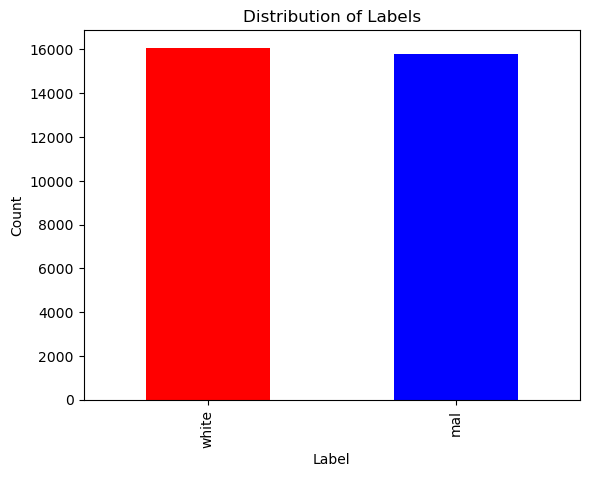

In [170]:
label_counts = train_df['label'].value_counts()
label_counts.plot(kind='bar', color=['red', 'blue'])
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [171]:
# duplicates = train_df[train_df.duplicated()]

# if duplicates.shape[0] > 0:
#     print(duplicates)

In [172]:
# # Remove all duplicate rows based on all columns
# train_df.drop_duplicates(inplace=True)

# # If you want to remove duplicates based on specific columns, you can use the subset parameter
# # For example, to remove duplicates based on the 'vba_code' column:
# train_df.drop_duplicates(subset=['vba_code'], inplace=True)
# train_df

In [173]:
# # Assuming 'label' is the column containing 'mal' and 'white' values
# label_counts = train_df['label'].value_counts()

# # Plotting the counts
# label_counts.plot(kind='bar', color=['red', 'blue'])
# plt.title('Distribution of Labels')
# plt.xlabel('Label')
# plt.ylabel('Count')
# plt.show()

### Extracting features

In [174]:
# mal = train_df[train_df['label'] == 'mal']
# white = train_df[train_df['label'] == 'white']
# mal.vba_code

In [175]:
# !pip install oletools

In [176]:
# basic obfuscation or not (use de-obfuscation methods if yes)
obfuscation_indicators = [
    'Chr(', 'Hex(', 'Execute(', 'Base64Decode(',
    'Environ(', 'Shell(', 'WScript.Shell', 'GetFile(', 'MSXML2.ServerXMLHTTP', 
    'CreateObject("MSXML2.XMLHTTP")', 'CreateObject("ADODB.Stream")', 
    'Randomize', 'Replace(', 'StrReverse(', 'CallByName(', 'GetObject(',
    'Xor', 'vbuicode', 'vbfromunicode', 'If False Then ... End If'
    ]

# Define a function to check for the presence of obfuscation indicators
def is_obfuscated(code):
    for indicator in obfuscation_indicators:
        if indicator in code:
            return 1
    return 0

In [177]:
train_df['is_obfuscated'] = train_df['vba_code'].apply(is_obfuscated)
# train_df

In [178]:
train_df[train_df['label'] == 'white']['is_obfuscated'].value_counts()

is_obfuscated
0    14108
1     1970
Name: count, dtype: int64

In [179]:
train_df[train_df['label'] == 'mal']['is_obfuscated'].value_counts()

is_obfuscated
1    12761
0     3049
Name: count, dtype: int64

In [180]:
# Text Length
train_df['code_length'] = train_df['vba_code'].apply(len)
# train_df

In [181]:
# Number of Linens
train_df['num_lines'] = train_df['vba_code'].apply(lambda x: x.count('\n') + 1)
# train_df

In [182]:
# Syntax Complexity: average number of characters per line
train_df['avg_chars_per_line'] = train_df.apply(lambda row: row['code_length'] / row['num_lines'] if row['num_lines'] > 0 else 0, axis=1)
# train_df

In [183]:
# Use of Punctuation
train_df['num_exclamation_marks'] = train_df.apply(lambda row: row['vba_code'].count('!') / row['code_length'] if row['code_length'] > 0 else 0, axis=1)
# train_df

In [184]:
# Language Features
train_df['num_loops'] = train_df['vba_code'].apply(lambda x: x.count('For') + x.count('While'))
# train_df

In [185]:
# Loops per Character Length
train_df['num_loops_length'] = train_df.apply(lambda row: (row['vba_code'].count('For ') + row['vba_code'].count('While')) / row['code_length'] if row['code_length'] > 0 else 0, axis=1)
# train_df

In [186]:
# Function/Procedure Count
train_df['num_functions'] = train_df['vba_code'].apply(lambda x: x.count('Sub ') + x.count('Function '))
# train_df

In [187]:
# Functions per Character Length:
train_df['num_functions'] = train_df.apply(lambda row: (row['vba_code'].count('Sub ') + row['vba_code'].count('Function ')) / row['code_length'] if row['code_length'] > 0 else 0, axis=1)
# train_df

In [188]:
# Numeric Literal Count (using regular expression)
train_df['num_numeric_literals'] = train_df.apply(lambda row: len(re.findall(r'\b\d+\b', row['vba_code'])) / row['code_length'] if row['code_length'] > 0 else 0, axis=1)
# train_df

In [189]:
# String Literal Count
train_df['num_string_literals'] = train_df.apply(lambda row: len(re.findall(r'"([^"]*)"', row['vba_code'])) / row['code_length'] if row['code_length'] > 0 else 0, axis=1)
# train_df

In [190]:
# Error Handling Presence
train_df['has_error_handling'] = train_df['vba_code'].apply(lambda x: 1 if 'On Error' in x else 0)
# train_df

In [191]:
# Define a function to check for the presence of URLs or IPs
def has_url_or_ip(code):
    # Regular expression pattern to match URLs or IPs
    pattern = re.compile(r'(https?://|ftp://|www\.)|((25[0-5]|2[0-4][0-9]|[0-1]?[0-9][0-9]?)\.){3}(25[0-5]|2[0-4][0-9]|[0-1]?[0-9][0-9]?)')

    # Check if the pattern is found in the code
    return 1 if pattern.search(code) else 0

In [192]:
train_df['has_url_or_ip'] = train_df['vba_code'].apply(has_url_or_ip)
# train_df

In [193]:
# private libraries (passwords, and personal data..)
information_disclosure_keywords = ['winmgmts', 'Win32_Process', 'shell', 
                                   'ssn', 'secret', 'pwd', 'shadow', 'bypass', 
                                  'EvilClippy', 'Base64Decode', 'CreateObject',
                                  'CommandLine', 'Auto_open', 'Replace', 'Based',
                                  'Worksheet_Change', 'bin.base64', 'xor', 'GetFile',
                                  'Shell', 'DownloadFile', 'Eval']

# Define a function to check for the presence of information disclosure keywords
def has_information_disclosure(code):
    for keyword in information_disclosure_keywords:
        if keyword in code.lower():
            return 1
    return 0

In [194]:
train_df['has_information_disclosure'] = train_df['vba_code'].apply(has_information_disclosure)
# train_df

In [195]:
# train_df['has_information_disclosure'].value_counts()
train_df[train_df['label'] == 'mal']['has_information_disclosure'].value_counts()

has_information_disclosure
0    14154
1     1656
Name: count, dtype: int64

In [196]:
train_df[train_df['label'] == 'white']['has_information_disclosure'].value_counts()

has_information_disclosure
0    15197
1      881
Name: count, dtype: int64

In [197]:
train_df

,label,vba_code,vba_code_without_comments,cleaned_vba_code,is_obfuscated,code_length,num_lines,avg_chars_per_line,num_exclamation_marks,num_loops,num_loops_length,num_functions,num_numeric_literals,num_string_literals,has_error_handling,has_url_or_ip,has_information_disclosure
0,white,Private Sub Workbook_BeforeClose(Cancel As Boo...,Private Sub Workbook_BeforeClose(Cancel As Boo...,private sub workbook_beforeclose cancel as boo...,0,1070,34,31.470588,0.000000,0,0.000000,0.003738,0.001869,0.005607,0,0,0
1,white,Option Explicit\nOption Explicit\nOption Expli...,Option Explicit\nOption Explicit\nOption Expli...,option explicit option explicit option explici...,0,13092,420,31.171429,0.000229,23,0.000687,0.002215,0.008631,0.006416,1,0,0
2,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,\nPrivate Sub Workbook_BeforeClose(Cancel As B...,private sub workbook_beforeclose cancel as bo...,1,3428,86,39.860465,0.002042,1,0.000292,0.002334,0.019253,0.008460,0,1,0
3,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,\nPrivate Sub Workbook_BeforeClose(Cancel As B...,private sub workbook_beforeclose cancel as bo...,1,3428,86,39.860465,0.002042,1,0.000292,0.002334,0.019253,0.008460,0,1,0
4,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,\nPrivate Sub Workbook_BeforeClose(Cancel As B...,private sub workbook_beforeclose cancel as bo...,1,3428,86,39.860465,0.002042,1,0.000292,0.002334,0.019253,0.008460,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31883,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,\nPrivate Sub Workbook_BeforeClose(Cancel As B...,private sub workbook_beforeclose cancel as bo...,1,3428,86,39.860465,0.002042,1,0.000292,0.002334,0.019253,0.008460,0,1,0
31884,white,Option Explicit\n\nPrivate Sub Workbook_Open()...,Option Explicit\n\nPrivate Sub Workbook_Open()...,option explicit private sub workbook_open ap...,0,12274,402,30.532338,0.000244,23,0.000081,0.003340,0.007414,0.003748,1,0,1
31885,white,Option Explicit\n\nPrivate Sub CFixPicture_Act...,Option Explicit\n\nPrivate Sub CFixPicture_Act...,option explicit private sub cfixpicture_activa...,0,1000,42,23.809524,0.000000,0,0.000000,0.006000,0.000000,0.000000,1,0,0
31886,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,\nPrivate Sub Workbook_BeforeClose(Cancel As B...,private sub workbook_beforeclose cancel as bo...,1,3428,86,39.860465,0.002042,1,0.000292,0.002334,0.019253,0.008460,0,1,0


### visualization

In [198]:
mal = train_df[train_df['label'] == 'mal']
white = train_df[train_df['label'] == 'white']

In [199]:
# train_df['label'] = train_df['label'].replace('white',1, regex=True) 
# train_df['label'] = train_df['label'].replace('mal',0, regex=True) 
train_df = train_df.drop('label', axis=1)

In [200]:
train_df.columns

Index(['vba_code', 'vba_code_without_comments', 'cleaned_vba_code',
       'is_obfuscated', 'code_length', 'num_lines', 'avg_chars_per_line',
       'num_exclamation_marks', 'num_loops', 'num_loops_length',
       'num_functions', 'num_numeric_literals', 'num_string_literals',
       'has_error_handling', 'has_url_or_ip', 'has_information_disclosure'],
      dtype='object')

In [201]:
col = ['code_length', 'num_lines', 'avg_chars_per_line',
       'num_exclamation_marks', 'num_loops', 'num_loops_length',
       'num_functions', 'num_numeric_literals', 'num_string_literals',
       'has_error_handling', 'has_url_or_ip', 'has_information_disclosure',
       'is_obfuscated']
corr_df = train_df[col]
corr_df

,code_length,num_lines,avg_chars_per_line,num_exclamation_marks,num_loops,num_loops_length,num_functions,num_numeric_literals,num_string_literals,has_error_handling,has_url_or_ip,has_information_disclosure,is_obfuscated
0,1070,34,31.470588,0.000000,0,0.000000,0.003738,0.001869,0.005607,0,0,0,0
1,13092,420,31.171429,0.000229,23,0.000687,0.002215,0.008631,0.006416,1,0,0,0
2,3428,86,39.860465,0.002042,1,0.000292,0.002334,0.019253,0.008460,0,1,0,1
3,3428,86,39.860465,0.002042,1,0.000292,0.002334,0.019253,0.008460,0,1,0,1
4,3428,86,39.860465,0.002042,1,0.000292,0.002334,0.019253,0.008460,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31883,3428,86,39.860465,0.002042,1,0.000292,0.002334,0.019253,0.008460,0,1,0,1
31884,12274,402,30.532338,0.000244,23,0.000081,0.003340,0.007414,0.003748,1,0,1,0
31885,1000,42,23.809524,0.000000,0,0.000000,0.006000,0.000000,0.000000,1,0,0,0
31886,3428,86,39.860465,0.002042,1,0.000292,0.002334,0.019253,0.008460,0,1,0,1


<Axes: >

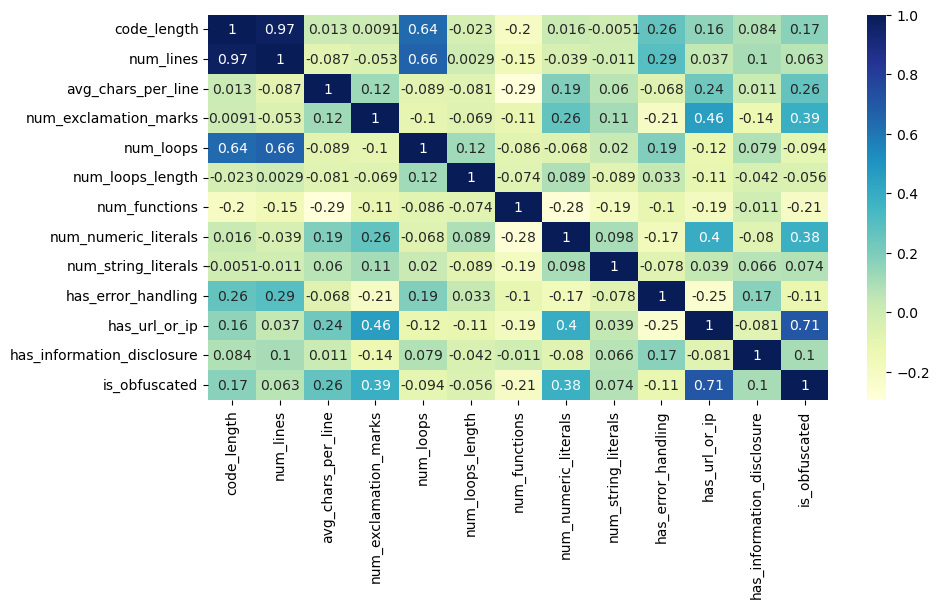

In [202]:
#correlation
plt.figure(figsize=(10,5))
sns.heatmap(corr_df.corr(),annot=True,cmap="YlGnBu")

In [203]:
train_df['has_url_or_ip'].value_counts()

has_url_or_ip
0    19072
1    12816
Name: count, dtype: int64

In [204]:
train_df['is_obfuscated'].value_counts()

is_obfuscated
0    17157
1    14731
Name: count, dtype: int64

In [205]:
train_df['has_error_handling'].value_counts()

has_error_handling
0    25244
1     6644
Name: count, dtype: int64

In [206]:
train_df['has_information_disclosure'].value_counts()

has_information_disclosure
0    29351
1     2537
Name: count, dtype: int64

Text(0.5, 1.0, 'Distributional of length')

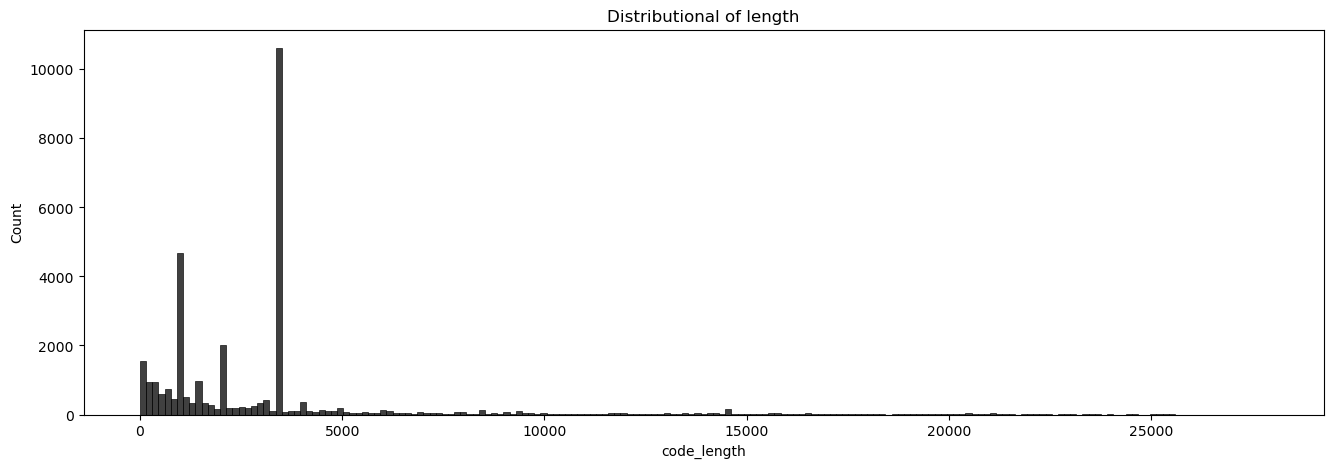

In [207]:
f, axes = plt.subplots(1,1, figsize = (16, 5))
g1 = sns.histplot(train_df['code_length'], color="black",ax = axes)
plt.title("Distributional of length")

<Axes: xlabel='code_length', ylabel='num_loops'>

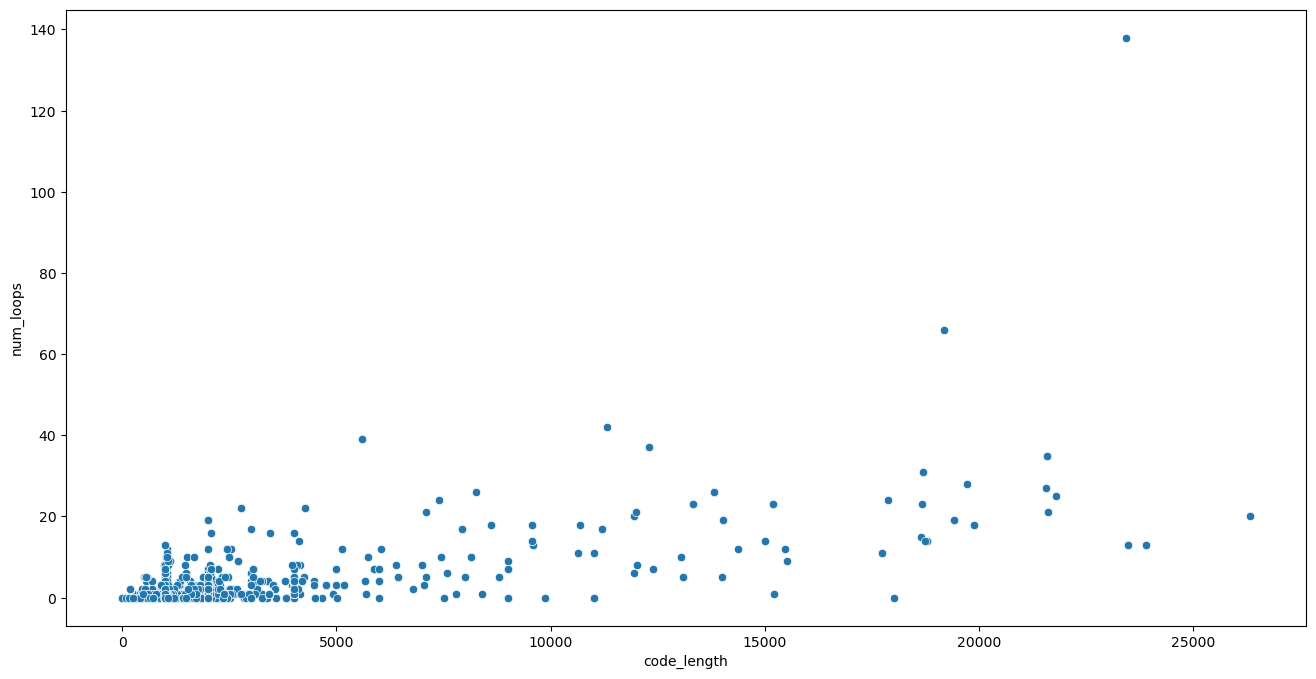

In [208]:
plt.figure(figsize = (16,8))
sns.scatterplot(x = mal['code_length'], y = mal['num_loops'])

<Axes: xlabel='code_length', ylabel='num_loops'>

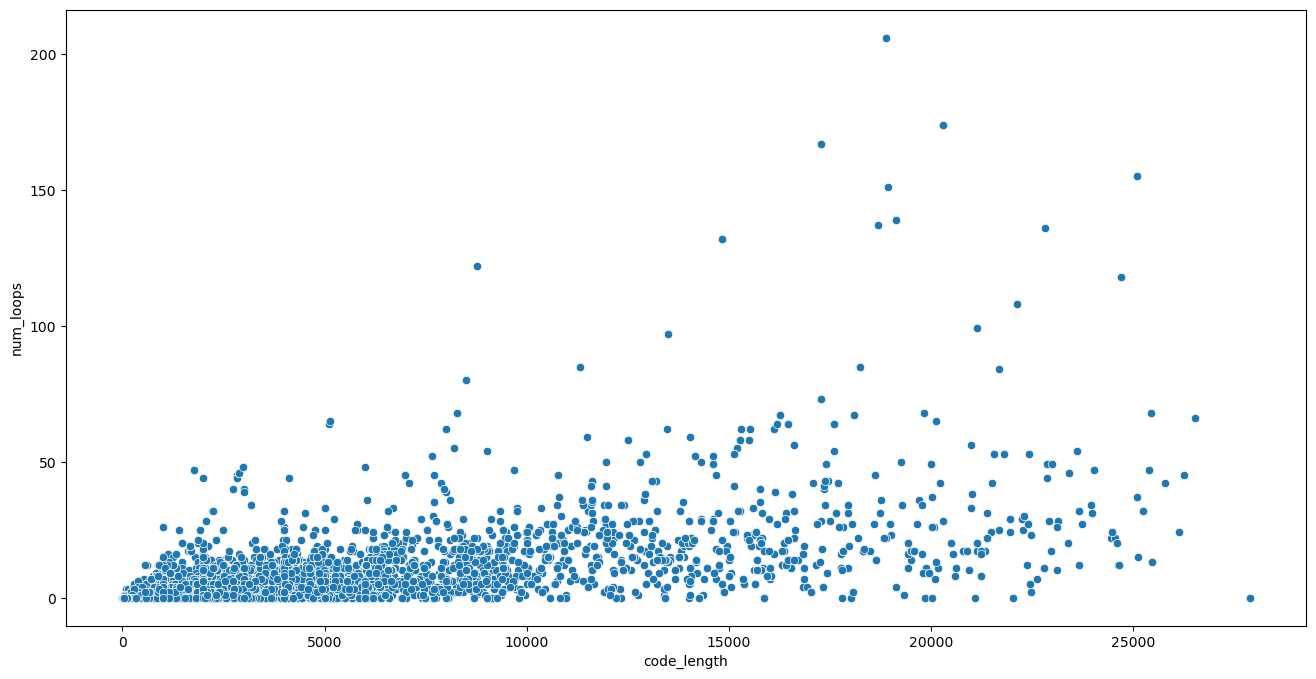

In [209]:
plt.figure(figsize = (16,8))
sns.scatterplot(x = white['code_length'], y = white['num_loops'])

<Axes: xlabel='is_obfuscated', ylabel='count'>

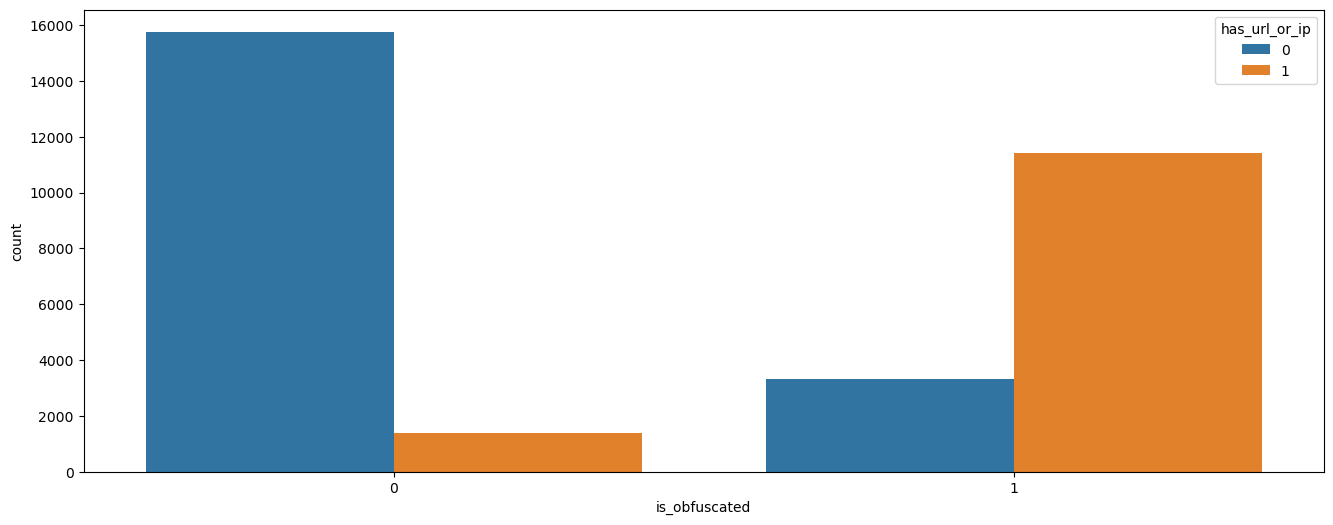

In [210]:
plt.figure(figsize=(16, 6))
sns.countplot(x='is_obfuscated', hue='has_url_or_ip', data=train_df)

# Features selection

In [211]:
# PCA, VarianceThreshold, SelectKBest, Tree-based feature selection

### VarianceThreshold

In [212]:
X = corr_df

threshold_value = .8 * (1 - .8)
vt = VarianceThreshold(threshold=threshold_value)

X_filtered = vt.fit_transform(X)

In [213]:
selected_features = X.columns[vt.get_support()]
selected_features

Index(['code_length', 'num_lines', 'avg_chars_per_line', 'num_loops',
       'has_error_handling', 'has_url_or_ip', 'is_obfuscated'],
      dtype='object')

### Principal component analysis (PCA)

In [214]:
X = corr_df
pca = PCA(n_components=7)
pca.fit(X)

print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[9.99906647e-01 7.37080027e-05 1.66746268e-05 2.92492425e-06
 2.32671525e-08 1.17176536e-08 6.18412940e-09]
[6.32605115e+05 5.43138131e+03 2.58333681e+03 1.08195770e+03
 9.64993949e+01 6.84815055e+01 4.97499050e+01]


In [215]:
coloumns = ['code_length', 'num_lines', 'avg_chars_per_line', 'num_loops',
        'has_error_handling', 'has_url_or_ip', 'is_obfuscated', 'num_string_literals',
        'has_information_disclosure', 'num_numeric_literals', 'num_exclamation_marks', 'num_functions']
train = train_df[coloumns]
train

,code_length,num_lines,avg_chars_per_line,num_loops,has_error_handling,has_url_or_ip,is_obfuscated,num_string_literals,has_information_disclosure,num_numeric_literals,num_exclamation_marks,num_functions
0,1070,34,31.470588,0,0,0,0,0.005607,0,0.001869,0.000000,0.003738
1,13092,420,31.171429,23,1,0,0,0.006416,0,0.008631,0.000229,0.002215
2,3428,86,39.860465,1,0,1,1,0.008460,0,0.019253,0.002042,0.002334
3,3428,86,39.860465,1,0,1,1,0.008460,0,0.019253,0.002042,0.002334
4,3428,86,39.860465,1,0,1,1,0.008460,0,0.019253,0.002042,0.002334
...,...,...,...,...,...,...,...,...,...,...,...,...
31883,3428,86,39.860465,1,0,1,1,0.008460,0,0.019253,0.002042,0.002334
31884,12274,402,30.532338,23,1,0,0,0.003748,1,0.007414,0.000244,0.003340
31885,1000,42,23.809524,0,1,0,0,0.000000,0,0.000000,0.000000,0.006000
31886,3428,86,39.860465,1,0,1,1,0.008460,0,0.019253,0.002042,0.002334


In [216]:
def set_data(df):
    df['code_length'] = df['vba_code'].apply(len)
    df['num_lines'] = df['vba_code'].apply(lambda x: x.count('\n') + 1)
    df['avg_chars_per_line'] = df.apply(lambda row: row['code_length'] / row['num_lines'] if row['num_lines'] > 0 else 0, axis=1)
    df['num_loops'] = df['vba_code'].apply(lambda x: x.count('For') + x.count('While'))
    df['has_error_handling'] = df['vba_code'].apply(lambda x: 1 if 'On Error' in x else 0)
    df['has_url_or_ip'] = df['vba_code'].apply(has_url_or_ip)
    df['is_obfuscated'] = df['vba_code'].apply(is_obfuscated)
    df['num_string_literals'] = df.apply(lambda row: len(re.findall(r'"([^"]*)"', row['vba_code'])) / row['code_length'] if row['code_length'] > 0 else 0, axis=1)
    df['has_information_disclosure'] = df['vba_code'].apply(has_information_disclosure)
    df['num_numeric_literals'] = df.apply(lambda row: len(re.findall(r'\b\d+\b', row['vba_code'])) / row['code_length'] if row['code_length'] > 0 else 0, axis=1)
    df['num_exclamation_marks'] = df.apply(lambda row: row['vba_code'].count('!') / row['code_length'] if row['code_length'] > 0 else 0, axis=1)
    df['num_functions'] = df.apply(lambda row: (row['vba_code'].count('Sub ') + row['vba_code'].count('Function ')) / row['code_length'] if row['code_length'] > 0 else 0, axis=1)
    
#     df = df.drop('vba_code', axis=1)
    return df

In [217]:
validation = set_data(validation_df)

In [218]:
validation

,label,vba_code,vba_code_without_comments,cleaned_vba_code,code_length,num_lines,avg_chars_per_line,num_loops,has_error_handling,has_url_or_ip,is_obfuscated,num_string_literals,has_information_disclosure,num_numeric_literals,num_exclamation_marks,num_functions
0,mal,Function SleekM()\nOn Error Resume Next\n Se...,Function SleekM()\nOn Error Resume Next\n Se...,function sleekm on error resume next select ...,1425,48,29.687500,0,1,0,0,0.000000,0,0.007719,0.000000,0.001404
1,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,\nPrivate Sub Workbook_BeforeClose(Cancel As B...,private sub workbook_beforeclose cancel as bo...,3428,86,39.860465,1,0,1,1,0.008460,0,0.019253,0.002042,0.002334
2,white,"'Sub AutoExec() 'ð2¾(\n'ds = MsgBox(""#Wzh...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,,393,28,14.035714,0,0,0,0,0.002545,0,0.007634,0.002545,0.020356
3,white,Private Sub CommandButton1_Click()\nCall Clear...,Private Sub CommandButton1_Click()\nCall Clear...,private sub commandbutton1_click call cleare...,726,23,31.565217,1,0,0,0,0.011019,0,0.004132,0.000000,0.004132
4,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,\nPrivate Sub Workbook_BeforeClose(Cancel As B...,private sub workbook_beforeclose cancel as bo...,3428,86,39.860465,1,0,1,1,0.008460,0,0.019253,0.002042,0.002334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10624,mal,Sub Auto_Open()\nApplication.EnableCancelKey =...,Sub Auto_Open()\nApplication.EnableCancelKey =...,sub auto_open application enablecancelkey ...,1000,26,38.461538,1,1,0,1,0.011000,0,0.004000,0.001000,0.002000
10625,white,"Private Sub UserForm_Initialize()\nTXTpath = ""...","Private Sub UserForm_Initialize()\nTXTpath = ""...",private sub userform_initialize txtpath c...,5924,250,23.696000,13,0,0,1,0.006077,0,0.019750,0.000000,0.001519
10626,white,Private Sub SpinButton1_Change()\n\nEnd Sub\n\...,Private Sub SpinButton1_Change()\n\nEnd Sub\n\...,private sub spinbutton1_change end sub priva...,11879,505,23.522772,6,0,0,0,0.014143,0,0.017594,0.000000,0.004630
10627,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,\nPrivate Sub Workbook_BeforeClose(Cancel As B...,private sub workbook_beforeclose cancel as bo...,3428,86,39.860465,1,0,1,1,0.008460,0,0.019253,0.002042,0.002334


# Training (Models)

In [219]:
from sklearn.neighbors import  KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import  roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

In [220]:
X_train = train
X_val = validation.drop(['label', 'vba_code_without_comments', 'cleaned_vba_code', 'vba_code'], axis=1)

In [221]:
# Concatenate additional features with Word2Vec features
X_train_combined = pd.concat([X_train_word2vec_df, X_train], axis=1)
X_val_combined = pd.concat([X_val_word2vec_df, X_val], axis=1)

In [222]:
X_train_combined

,w2v_0,w2v_1,w2v_2,w2v_3,w2v_4,w2v_5,w2v_6,w2v_7,w2v_8,w2v_9,...,avg_chars_per_line,num_loops,has_error_handling,has_url_or_ip,is_obfuscated,num_string_literals,has_information_disclosure,num_numeric_literals,num_exclamation_marks,num_functions
0,2.086917,-0.351255,-0.575271,0.761152,-0.369170,0.721485,1.964624,-0.354101,0.137664,0.196184,...,31.470588,0,0,0,0,0.005607,0,0.001869,0.000000,0.003738
1,1.766929,-0.144191,-0.143384,0.235905,-0.441474,0.461649,2.060792,0.106433,-0.810641,-0.287002,...,31.171429,23,1,0,0,0.006416,0,0.008631,0.000229,0.002215
2,1.947131,0.203885,-0.234769,0.940292,-0.213648,-0.322162,1.316763,0.558559,-1.080564,-0.068845,...,39.860465,1,0,1,1,0.008460,0,0.019253,0.002042,0.002334
3,1.947131,0.203885,-0.234769,0.940292,-0.213648,-0.322162,1.316763,0.558559,-1.080564,-0.068845,...,39.860465,1,0,1,1,0.008460,0,0.019253,0.002042,0.002334
4,1.947131,0.203885,-0.234769,0.940292,-0.213648,-0.322162,1.316763,0.558559,-1.080564,-0.068845,...,39.860465,1,0,1,1,0.008460,0,0.019253,0.002042,0.002334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31883,1.947131,0.203885,-0.234769,0.940292,-0.213648,-0.322162,1.316763,0.558559,-1.080564,-0.068845,...,39.860465,1,0,1,1,0.008460,0,0.019253,0.002042,0.002334
31884,1.819271,-0.126206,-0.187451,0.548974,-0.554690,0.353507,1.808360,1.179103,-1.043226,0.181902,...,30.532338,23,1,0,0,0.003748,1,0.007414,0.000244,0.003340
31885,1.334873,-0.535600,-0.368718,0.730203,-0.227561,0.945213,2.500236,-0.493844,0.498311,0.032746,...,23.809524,0,1,0,0,0.000000,0,0.000000,0.000000,0.006000
31886,1.947131,0.203885,-0.234769,0.940292,-0.213648,-0.322162,1.316763,0.558559,-1.080564,-0.068845,...,39.860465,1,0,1,1,0.008460,0,0.019253,0.002042,0.002334


In [223]:
X_val_combined

,w2v_0,w2v_1,w2v_2,w2v_3,w2v_4,w2v_5,w2v_6,w2v_7,w2v_8,w2v_9,...,avg_chars_per_line,num_loops,has_error_handling,has_url_or_ip,is_obfuscated,num_string_literals,has_information_disclosure,num_numeric_literals,num_exclamation_marks,num_functions
0,1.589956,-0.526333,0.063587,0.092134,-1.486537,-0.143856,1.034182,1.211890,-2.134789,1.325740,...,29.687500,0,1,0,0,0.000000,0,0.007719,0.000000,0.001404
1,1.947131,0.203885,-0.234769,0.940292,-0.213648,-0.322162,1.316763,0.558559,-1.080564,-0.068845,...,39.860465,1,0,1,1,0.008460,0,0.019253,0.002042,0.002334
2,0.965606,0.940957,-0.166224,-0.307953,0.282816,1.168903,1.648142,-0.465624,-0.727383,-0.195006,...,14.035714,0,0,0,0,0.002545,0,0.007634,0.002545,0.020356
3,2.132810,-0.720312,-0.878371,0.323176,-0.349337,0.460102,1.949467,-0.504593,0.051860,0.171858,...,31.565217,1,0,0,0,0.011019,0,0.004132,0.000000,0.004132
4,1.947131,0.203885,-0.234769,0.940292,-0.213648,-0.322162,1.316763,0.558559,-1.080564,-0.068845,...,39.860465,1,0,1,1,0.008460,0,0.019253,0.002042,0.002334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10624,2.836410,-0.431209,0.411615,0.883012,-0.222022,-0.581587,1.042093,0.930514,-1.987864,-0.365516,...,38.461538,1,1,0,1,0.011000,0,0.004000,0.001000,0.002000
10625,1.529354,-0.041494,0.122883,0.588761,-0.761116,-0.012821,1.468277,1.010500,-1.309140,0.180982,...,23.696000,13,0,0,1,0.006077,0,0.019750,0.000000,0.001519
10626,1.775422,0.352590,-0.300479,-0.452533,-0.079237,0.485851,1.912495,0.280076,-0.982716,0.389163,...,23.522772,6,0,0,0,0.014143,0,0.017594,0.000000,0.004630
10627,1.947131,0.203885,-0.234769,0.940292,-0.213648,-0.322162,1.316763,0.558559,-1.080564,-0.068845,...,39.860465,1,0,1,1,0.008460,0,0.019253,0.002042,0.002334


In [224]:
# # split
# X_train = X_train_combined
# X_val = X_val_combined

### Gaussian Naive Bayes

In [225]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train_combined, y_train)
gnb_pred = gnb.predict(X_val_combined)
print(metrics.accuracy_score(y_val, gnb_pred))

0.808072255151002


In [226]:
report = classification_report(y_val, gnb_pred)
print(report)

              precision    recall  f1-score   support

           0       0.84      0.76      0.80      5320
           1       0.78      0.85      0.82      5309

    accuracy                           0.81     10629
   macro avg       0.81      0.81      0.81     10629
weighted avg       0.81      0.81      0.81     10629



### Decision tree

In [227]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=0)
dtc.fit(X_train_combined, y_train)
dtc_pred = dtc.predict(X_val_combined)
print(metrics.accuracy_score(y_val, dtc_pred))

0.9881456392887383


In [228]:
report = classification_report(y_val, dtc_pred)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5320
           1       0.99      0.99      0.99      5309

    accuracy                           0.99     10629
   macro avg       0.99      0.99      0.99     10629
weighted avg       0.99      0.99      0.99     10629



## Ensemble learning

### Random Forest Classification

In [229]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train_combined, y_train)
rfc_pred = rfc.predict(X_val_combined)
print(metrics.accuracy_score(y_val, rfc_pred))
print(classification_report(y_val, rfc_pred))

0.9931319973656976
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5320
           1       0.99      1.00      0.99      5309

    accuracy                           0.99     10629
   macro avg       0.99      0.99      0.99     10629
weighted avg       0.99      0.99      0.99     10629



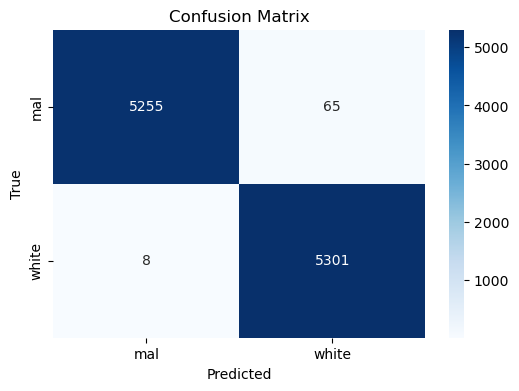

In [230]:
con_mat = confusion_matrix(y_val, rfc_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(con_mat, annot=True, fmt='g', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Gradient Boosting Classifier

In [231]:
from sklearn.ensemble import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train_combined, y_train)
y_val_pred = gb_clf.predict(X_val_combined)
print("Test Accuracy:", accuracy_score(y_val, y_val_pred))

Test Accuracy: 0.9750682096152037


### xgboost

In [232]:
# !pip install xgboost

In [233]:
import xgboost
xgb_clf = xgboost.XGBClassifier()
xgb_clf.fit(X_train_combined, y_train)
xgb_pred = xgb_clf.predict(X_val_combined)

In [234]:
print("xgboost score: ", xgb_clf.score(X_val_combined, y_val)*100)
print(classification_report(y_val, xgb_pred))

xgboost score:  99.45432307837049
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5320
           1       0.99      1.00      0.99      5309

    accuracy                           0.99     10629
   macro avg       0.99      0.99      0.99     10629
weighted avg       0.99      0.99      0.99     10629



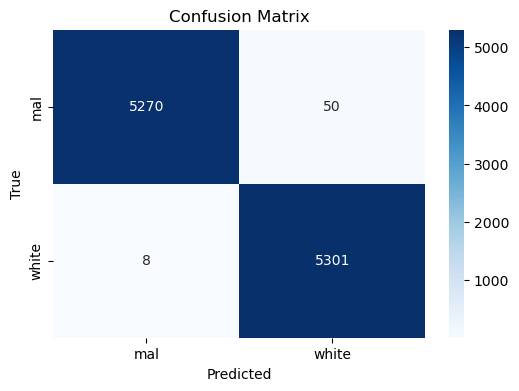

In [235]:
con_mat = confusion_matrix(y_val, xgb_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(con_mat, annot=True, fmt='g', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### AdaBoost

In [236]:
# from sklearn.ensemble import AdaBoostClassifier
# adaboost_model = AdaBoostClassifier(n_estimators=500)
# adaboost_model.fit(X_train, y_train)

# # Make predictions on the test set
# y_test_pred = adaboost_model.predict(X_val)

# # Evaluate the model
# print("Test Accuracy:", accuracy_score(y_val, y_test_pred))
# print("\nClassification Report:\n", classification_report(y_val, y_test_pred))

In [237]:
# cm = confusion_matrix(y_val, y_test_pred)
# plt.figure(figsize=(6, 4))
# sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')
# plt.show()

# Try PCA

In [238]:
# X_val_word2vec_df
# X_train_word2vec_df

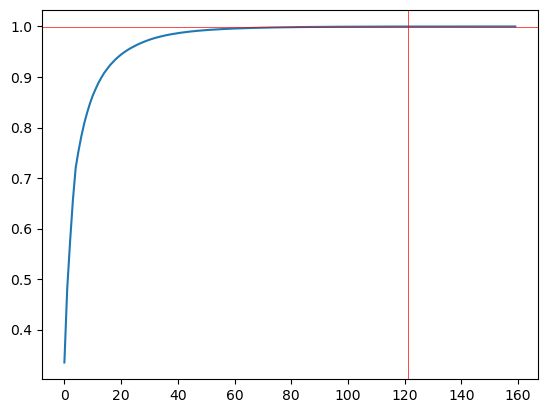

In [260]:
pca = PCA()
pca.fit(X_train_word2vec_df)
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumsum)
plt.axhline(y=0.9999, linewidth=0.5, color='r');
plt.axvline(x=121, linewidth=0.5, color='r');

In [261]:
pca = PCA(n_components=0.9999)
X_train_reduced = pca.fit_transform(X_train_word2vec_df)
X_val_reduced = pca.transform(X_val_word2vec_df)

In [262]:
pca.n_components_

121

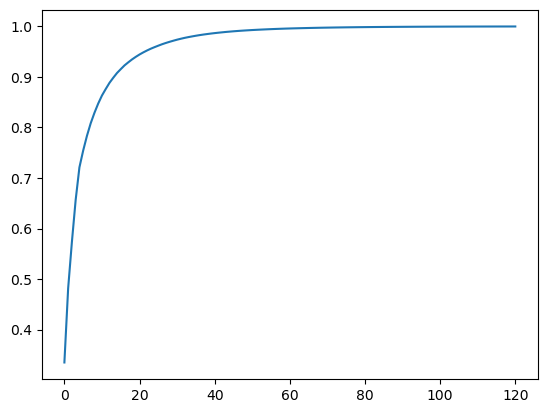

In [263]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumsum)

In [243]:
X_train_PCA = pd.DataFrame(X_train_reduced)
X_val_PCA = pd.DataFrame(X_val_reduced)

In [244]:
X_train_combined_pca = pd.concat([X_train_PCA, X_train], axis=1)
X_val_combined_pca = pd.concat([X_val_PCA, X_val], axis=1)

In [245]:
X_train_combined_pca.columns = X_train_combined_pca.columns.astype(str)
X_val_combined_pca.columns = X_val_combined_pca.columns.astype(str)

In [246]:
X_val_combined_pca

,0,1,2,3,4,5,6,7,8,9,...,avg_chars_per_line,num_loops,has_error_handling,has_url_or_ip,is_obfuscated,num_string_literals,has_information_disclosure,num_numeric_literals,num_exclamation_marks,num_functions
0,-3.934096,1.155354,-2.226875,0.013289,1.111455,-5.524482,-0.957398,-0.772843,0.439094,-0.398820,...,29.687500,0,1,0,0,0.000000,0,0.007719,0.000000,0.001404
1,-3.086982,-2.360232,1.189475,0.506183,-0.405530,0.021410,-0.096798,0.425137,-0.128195,-0.068813,...,39.860465,1,0,1,1,0.008460,0,0.019253,0.002042,0.002334
2,1.753440,-0.828662,1.198129,-2.494688,1.005750,-0.253638,0.553711,-2.845085,-0.220547,0.308456,...,14.035714,0,0,0,0,0.002545,0,0.007634,0.002545,0.020356
3,0.570726,0.192613,2.316392,-3.813603,1.816916,0.785590,2.983871,-0.354387,-1.898038,-0.300649,...,31.565217,1,0,0,0,0.011019,0,0.004132,0.000000,0.004132
4,-3.086982,-2.360232,1.189475,0.506183,-0.405530,0.021410,-0.096798,0.425137,-0.128195,-0.068813,...,39.860465,1,0,1,1,0.008460,0,0.019253,0.002042,0.002334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10624,-0.398511,-1.488398,-3.619237,3.012963,1.084105,2.859487,-1.293633,-1.744655,2.033336,0.570546,...,38.461538,1,1,0,1,0.011000,0,0.004000,0.001000,0.002000
10625,-1.239329,0.194603,-1.208212,0.144141,0.580451,0.102097,1.090468,-1.432416,-0.837796,-0.627825,...,23.696000,13,0,0,1,0.006077,0,0.019750,0.000000,0.001519
10626,1.980054,-0.143852,-0.320855,-3.019042,3.402150,-0.528425,-1.357926,0.651383,-0.279825,-0.548437,...,23.522772,6,0,0,0,0.014143,0,0.017594,0.000000,0.004630
10627,-3.086982,-2.360232,1.189475,0.506183,-0.405530,0.021410,-0.096798,0.425137,-0.128195,-0.068813,...,39.860465,1,0,1,1,0.008460,0,0.019253,0.002042,0.002334


#### PCA random forest

In [247]:
rfc_pca = RandomForestClassifier()
rfc_pca.fit(X_train_combined_pca, y_train)
rfc_pred_pca = rfc_pca.predict(X_val_combined_pca)
print(rfc_pca.score(X_val_combined_pca, y_val))
print(metrics.accuracy_score(y_val, rfc_pred_pca))
print(classification_report(y_val, rfc_pred_pca))

0.9934142440492991
0.9934142440492991
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5320
           1       0.99      1.00      0.99      5309

    accuracy                           0.99     10629
   macro avg       0.99      0.99      0.99     10629
weighted avg       0.99      0.99      0.99     10629



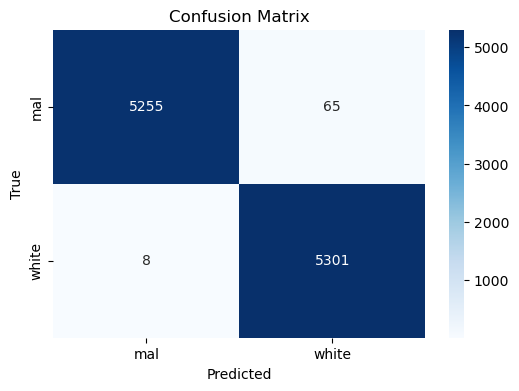

In [248]:
con_mat = confusion_matrix(y_val, rfc_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(con_mat, annot=True, fmt='g', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#### PCA XGBoost

In [249]:
xgb_clf_pca = xgboost.XGBClassifier()
xgb_clf_pca.fit(X_train_combined_pca, y_train)
xgb_pred_pca = xgb_clf_pca.predict(X_val_combined_pca)
print(xgb_clf_pca.score(X_val_combined_pca, y_val))
print(metrics.accuracy_score(y_val, xgb_pred_pca))
print(classification_report(y_val, xgb_pred_pca))

0.9959544642017123
0.9959544642017123
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      5320
           1       0.99      1.00      1.00      5309

    accuracy                           1.00     10629
   macro avg       1.00      1.00      1.00     10629
weighted avg       1.00      1.00      1.00     10629



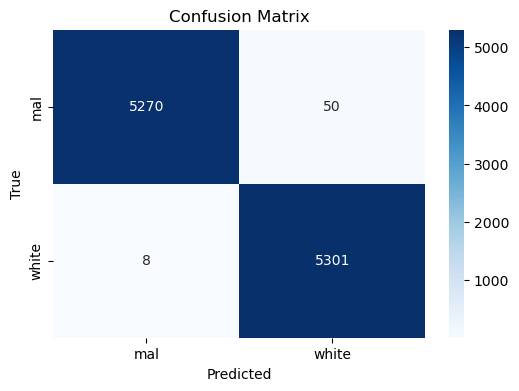

In [250]:
con_mat = confusion_matrix(y_val, xgb_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(con_mat, annot=True, fmt='g', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [251]:
# incorrect_indices = np.where(y_val != xgb_pred)[0]
# for i in incorrect_indices:
#     actual = y_val[i]
#     predicted = xgb_pred[i]
#     print(f"Instance {i}: Actual={actual}, Predicted={predicted}")
# #     print("Features:\n", X_val_combined_pca.iloc[i])
#     print('---------------------------------------------\n')

In [252]:
# validation['vba_code'][486]

In [253]:
# validation['is_obfuscated'][486]

In [254]:
# validation['label'][50]

# Predictions using test data

In [255]:
import pickle

# save the iris classification model as a pickle file
model_pkl_file = "model.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(xgb_clf_pca, file)